In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

In [19]:
def geography(left, right, bottom, top):
    #
    a = 2160
    b = 4320
    gl5shape = (a, b)
    #
    upperindex = (90-top)*12
    lowerindex = (90-bottom)*12
    leftindex = (180+left)*12
    rightindex = (180+right)*12
    #
    rgnshape = (lowerindex-upperindex, rightindex-leftindex)
    #
    img_extent = (left, right, bottom, top)
    
    return upperindex, lowerindex, leftindex, rightindex, rgnshape, img_extent

left = 138
right = 141
bottom = 34
top = 37
upperindex, lowerindex, leftindex, rightindex, rgnshape, img_extent = geography(left, right, bottom, top)

[0.000e+00 1.000e+00 2.000e+00 ... 1.858e+03 1.859e+03 1.860e+03]


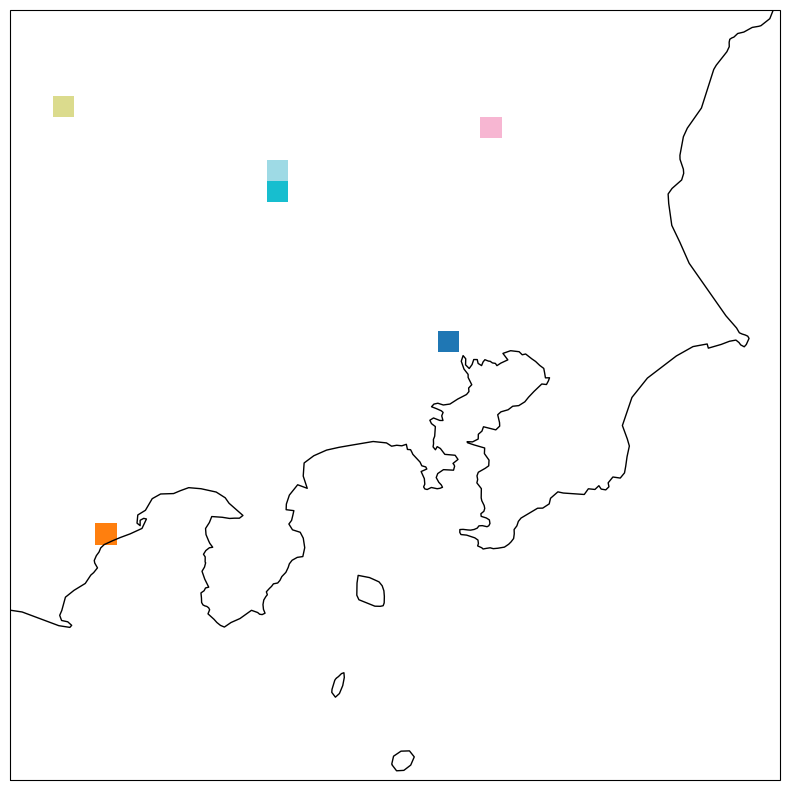

In [3]:
#################################3
# city center visualize
#################################3


h08dir = '/mnt/c/Users/tsimk/Downloads/dotfiles/h08/global_city'
ctycnt_path = f'{h08dir}/dat/cty_cnt_/gpw4/city_clrd0000.gl5'
ctycnt_gl5 = np.fromfile(ctycnt_path, dtype='float32').reshape(2160, 4320)
ctycnt_cropped = ctycnt_gl5[upperindex:lowerindex, leftindex:rightindex]
ctycnt_masked = np.ma.masked_where(ctycnt_cropped==0, ctycnt_cropped)

# check if unique value existis for city center
unq = np.unique(ctycnt_gl5)
print(unq)

# draw
projection = ccrs.PlateCarree()

fig = plt.figure(figsize=(10, 10))
ax = plt.subplot(projection=projection)
im = ax.imshow(ctycnt_masked,
               extent=img_extent, transform=projection, cmap='tab20')
ax.coastlines()

#west, east, south, north = 138, 141, 34, 37
#ax.set_xlim(west, east)
#ax.set_ylim(south, north)

plt.show()

In [4]:
# downtownアルゴリズムが発動している都市のみを抽出したい
# camacity_first.txtの３列を参照する

In [7]:
#name of the camacity file
cmct_name = '/mnt/c/Users/tsimk/Downloads/dotfiles/h08/camacity/dat/cty_lst_/camacity_first.txt'

table = []
dwntwn_list = []

with open(cmct_name, encoding="utf8") as file:
    for line in file:
        row = line.strip().split('|')
        table.append(row)

for row in table:
    if row[2] == 'True':
        dwntwn_list.append(int(row[0]))

print('Number of dwntwn cities : ',len(dwntwn_list))
print(dwntwn_list)

Number of dwntwn cities :  178
[1, 3, 5, 6, 7, 8, 10, 12, 14, 16, 17, 20, 21, 22, 24, 25, 29, 31, 34, 42, 46, 49, 52, 55, 56, 57, 58, 59, 62, 63, 65, 67, 68, 69, 70, 71, 72, 73, 77, 78, 79, 80, 85, 86, 87, 89, 90, 93, 94, 95, 102, 104, 107, 110, 112, 120, 121, 135, 140, 141, 143, 145, 150, 151, 156, 163, 165, 173, 179, 182, 185, 190, 194, 203, 205, 208, 210, 214, 222, 224, 229, 230, 231, 234, 241, 247, 248, 259, 263, 265, 270, 277, 281, 286, 288, 304, 306, 315, 316, 318, 327, 336, 346, 348, 349, 350, 351, 366, 367, 369, 372, 375, 380, 385, 386, 397, 406, 411, 437, 445, 458, 468, 470, 482, 486, 488, 489, 490, 496, 504, 515, 518, 571, 580, 605, 610, 696, 710, 713, 727, 745, 756, 791, 821, 824, 830, 832, 834, 843, 867, 869, 891, 945, 957, 984, 1009, 1016, 1018, 1047, 1065, 1113, 1149, 1160, 1165, 1168, 1171, 1202, 1205, 1222, 1223, 1227, 1236, 1269, 1313, 1368, 1379, 1690, 1795]


In [13]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cmaps
from matplotlib.colors import LogNorm
from matplotlib.colors import ListedColormap
import matplotlib.colors as colors
import cartopy.feature as cfea

In [18]:
def draw_mask(mask_temp, pop_temp, city_index, added_density, next_density, best_masked_pop, un_pop, best_coverage, next_coords):
    # cmap
    pop_vmax = 1e5
    
    # get city lonlat
    upperindex, lowerindex, leftindex, rightindex, rgnshape, img_extent = geography(left, right, bottom, top)

    # crop
    mask_cropped = mask_temp[upperindex:lowerindex, leftindex:rightindex]
    
    # pop
    pop_cropped = pop_temp[upperindex:lowerindex, leftindex:rightindex]

    # delta
    delta = 360/4320
    x_left = img_extent[0]
    y_top = img_extent[3]
    
    # outer
    upper_indices = []
    lower_indices = []
    left_indices = []
    right_indices = []
    rows, cols = mask_cropped.shape
    for i in range(rows):
        for j in range(cols):
            if mask_cropped[i, j] == 1:
                if mask_cropped[i-1, j] == 0:
                    upper_indices.append((i, j))
                if mask_cropped[i+1, j] == 0:
                    lower_indices.append((i, j))
                if mask_cropped[i, j-1] == 0:
                    left_indices.append((i, j))
                if mask_cropped[i, j+1] == 0:
                    right_indices.append((i, j))
    
    # extent
    projection = ccrs.PlateCarree()

    # figure
    fig = plt.figure(figsize=(10,10))
    ax = plt.subplot(projection=projection)
    ax.coastlines()
    ax.set_extent(img_extent)
    ax.gridlines(draw_labels=True)
    im = ax.imshow(pop_cropped,
                   origin='upper',extent=img_extent, transform=projection, cmap='gist_heat_r')
    
    seethrough = np.ma.masked_where(mask_cropped == 0, mask_cropped)
    seethrough[-1, -1] = 0
    citymask_cmap = plt.cm.colors.ListedColormap(['white', '#999999'])
    im2 = ax.imshow(seethrough,
                    origin='upper',extent=img_extent, transform=projection, cmap=citymask_cmap, alpha=0.5
                   )

    # city mask
    sotowaku_color = 'black'
    linewidth = 5
    for up in upper_indices:
        x_index = x_left + delta*(up[1])
        y_index = y_top - delta*(up[0])
        ax.plot([x_index, x_index+delta], [y_index, y_index], color=sotowaku_color, transform=projection, linewidth=linewidth) # top
    for lo in lower_indices:
        x_index = x_left + delta*(lo[1])
        y_index = y_top - delta*(lo[0]+1)
        ax.plot([x_index, x_index+delta], [y_index, y_index], color=sotowaku_color, transform=projection, linewidth=linewidth) # bottom
    for le in left_indices:
        x_index = x_left + delta*(le[1])
        y_index = y_top - delta*(le[0]+1)
        ax.plot([x_index, x_index], [y_index, y_index+delta], color=sotowaku_color, transform=projection, linewidth=linewidth) # left
    for ri in right_indices:
        x_index = x_left + delta*(ri[1]+1)
        y_index = y_top - delta*(ri[0]+1)
        ax.plot([x_index, x_index], [y_index, y_index+delta], color=sotowaku_color, transform=projection, linewidth=linewidth) # right

    # next grid
    next_y = 90 - (next_coords[1]+1)*delta
    next_x = (next_coords[2]+1)*delta -180
    ax.plot([next_x - delta, next_x, next_x, next_x - delta, next_x - delta], 
             [next_y, next_y, next_y + delta, next_y + delta, next_y], 
             color='blue', transform=projection, linewidth=linewidth) # right

In [9]:
def get_text_positions(x_data, y_data, txt_width, txt_height):
    a = list(zip(y_data, x_data))
    text_positions = y_data.copy()

    for index, (y, x) in enumerate(a):
        local_text_positions = [i for i in a if i[0] > (y - txt_height) and (abs(i[1] - x) < txt_width * 2) and i != (y, x)]
        if local_text_positions:
            sorted_ltp = sorted(local_text_positions)
            if abs(sorted_ltp[0][0] - y) < txt_height:
                differ = np.diff(sorted_ltp, axis=0)
                a[index] = (sorted_ltp[-1][0] + txt_height, a[index][1])
                text_positions[index] = sorted_ltp[-1][0] + txt_height
                for k, (j, m) in enumerate(differ):
                    if j > txt_height * 1.5:
                        a[index + k + 1] = (sorted_ltp[k][0] + txt_height, a[index + k + 1][1])
                        text_positions[index + k + 1] = sorted_ltp[k][0] + txt_height
            else:
                text_positions[index] = y - txt_height
        else:
            text_positions[index] = y - txt_height

    return text_positions

In [14]:
index = 1
h08dir = '/mnt/c/Users/tsimk/Downloads/dotfiles/h08/global_city'
load_path = f'{h08dir}/dat/dwn_twn_/city_{index:08}.pickle'
with open(load_path, 'rb') as file:
    load_dict = pickle.load(file)

[52, 63, 89, 93, 95, 98, 105, 120, 125, 126, 132, 134, 135, 148, 158]


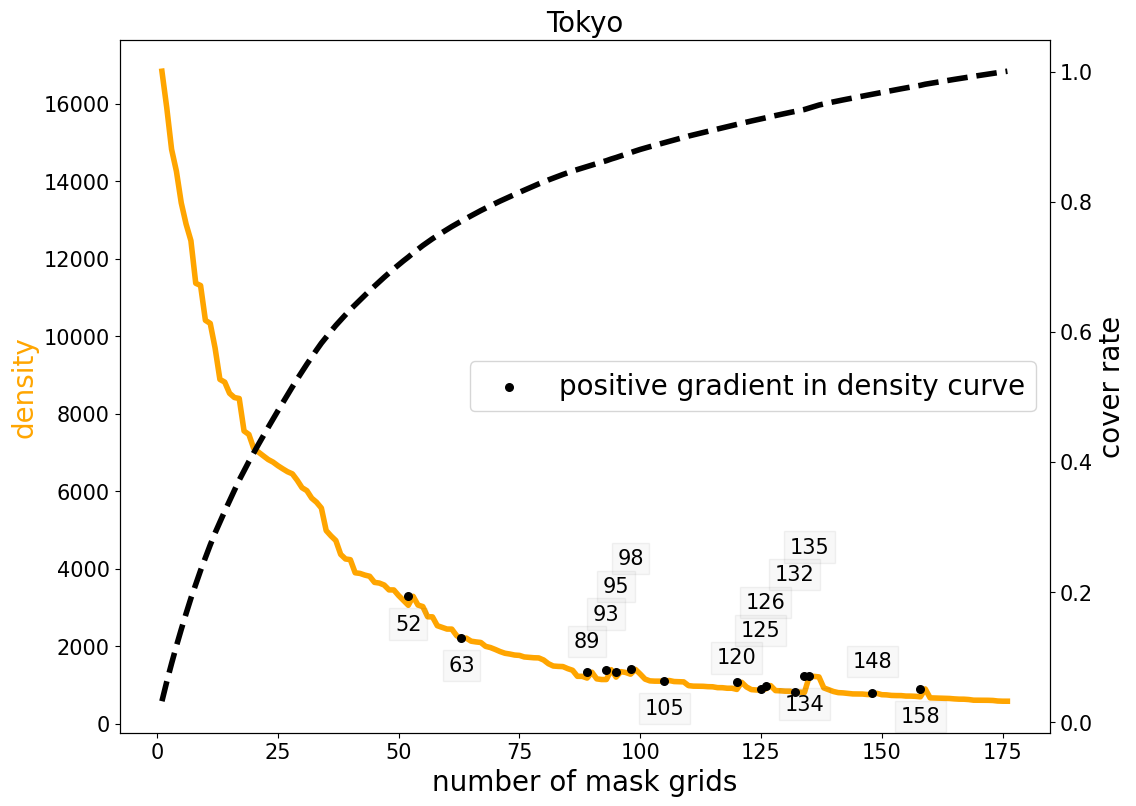

In [16]:
density_trace = load_dict['added_density']
cover_trace = load_dict['cover_rate']

xrange = np.arange(1, len(density_trace)+1)

back_index = []
for i in (xrange[:-1]):
    if density_trace[i] > density_trace[i-1]:
        back_index.append(i)
print(back_index)
back_density = [density_trace[b] for b in back_index]

plt.rcParams.update({'font.size': 15})
fig, ax1 = plt.subplots(figsize=(12, 9))

ax1.plot(xrange, density_trace, linewidth='4', color='orange')
ax1.scatter(back_index, back_density, color='black', s=30, label='positive gradient in density curve', zorder=2)
ax1.set_xlabel('number of mask grids', fontsize='20')
ax1.set_ylabel('density', color='orange', fontsize='20')
ax1.legend(loc='right', fontsize='20')

txt_height = 0.04 * (plt.ylim()[1] - plt.ylim()[0])
txt_width = 0.03 * (plt.xlim()[1] - plt.xlim()[0])
text_positions = get_text_positions(back_index, back_density, txt_width, txt_height)
for xi, yi in zip(back_index, text_positions):
    ax1.text(xi, yi, xi, ha='center', va='center', bbox=dict(facecolor='gray', alpha=0.05))

ax2 = ax1.twinx()
ax2.plot(xrange, cover_trace, linestyle='--', linewidth='4', color='black', zorder= 0.5)
ax2.set_ylabel('cover rate', color='black', fontsize='20')
plt.title('Tokyo', fontsize='20')
plt.show()

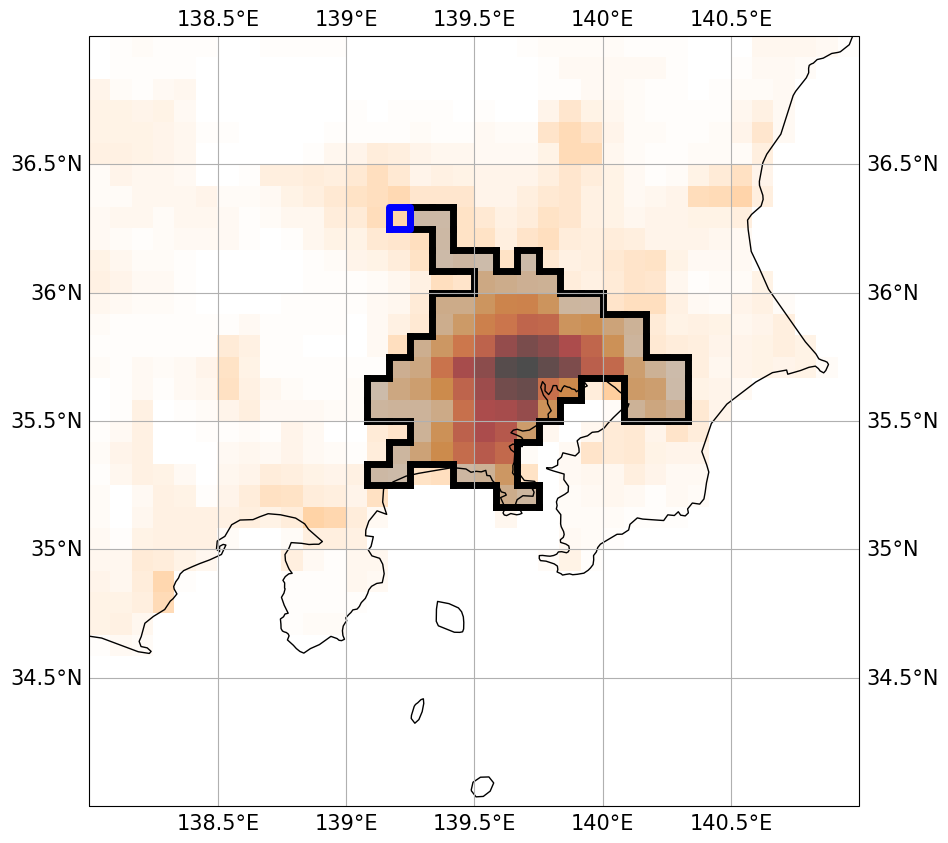

In [28]:
check_list = [52, 63, 89, 93, 95, 98, 105, 120, 125, 126, 132, 134, 135, 148, 158]

mask_num = 98
city_index = 1

bestmask_trace = load_dict['mask']
density_trace = load_dict['added_density']
nextdensity_trace = load_dict['next_density']
totalpop_trace = load_dict['masked_population']
coverage_trace = load_dict['cover_rate']
nextcoords_trace = load_dict['next_coords']
un_pop = load_dict['un_population']
#gwp_pop_density = load_dict['population_density']

gpw_path = '/mnt/c/Users/tsimk/Downloads/dotfiles/h08/global_city/dat/pop_tot_/GPW4ag__20100000.gl5'
gpw_pop = np.fromfile(gpw_path, dtype='float32').reshape(2160, 4320)
gwp_pop_density = gpw_pop

mask_tmp = bestmask_trace[:, :, mask_num-1]
prv = density_trace[mask_num-1]
nxt = nextdensity_trace[mask_num-1]
pop = totalpop_trace[mask_num-1]
cov = coverage_trace[mask_num-1]
cor = nextcoords_trace[mask_num-1]

draw_mask(mask_tmp, gwp_pop_density, city_index, np.round(prv), np.round(nxt), pop, un_pop, cov, cor)

52
63
89
93
95
98
105
120
125
126
132
134
135
148
158


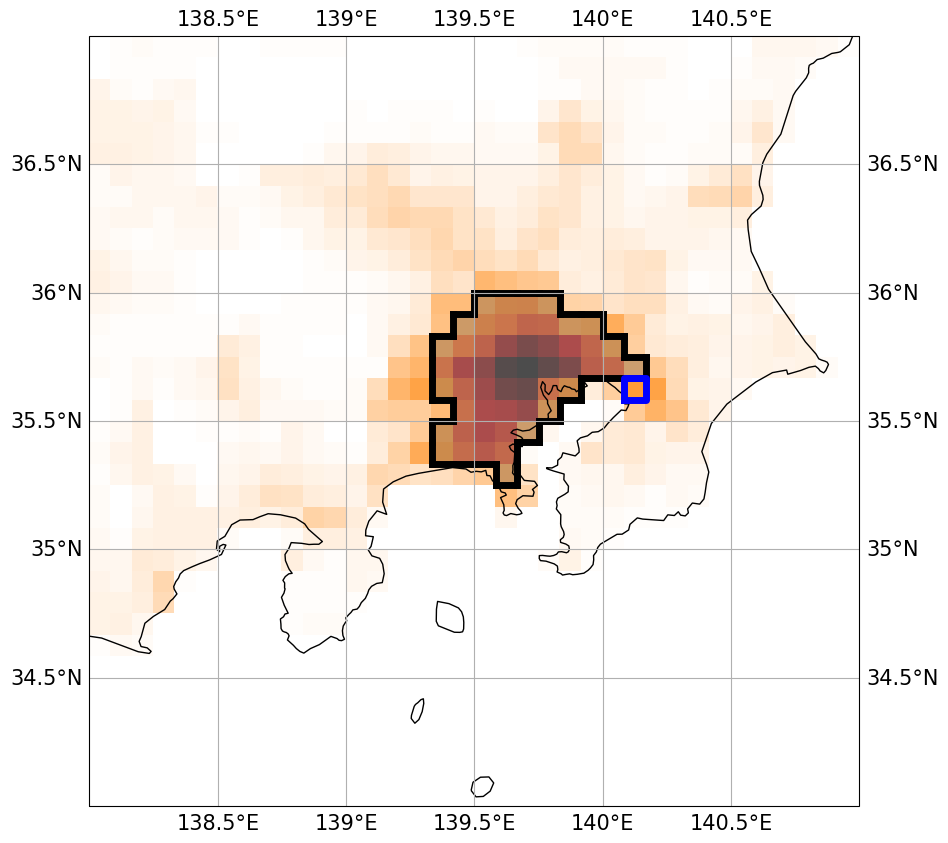

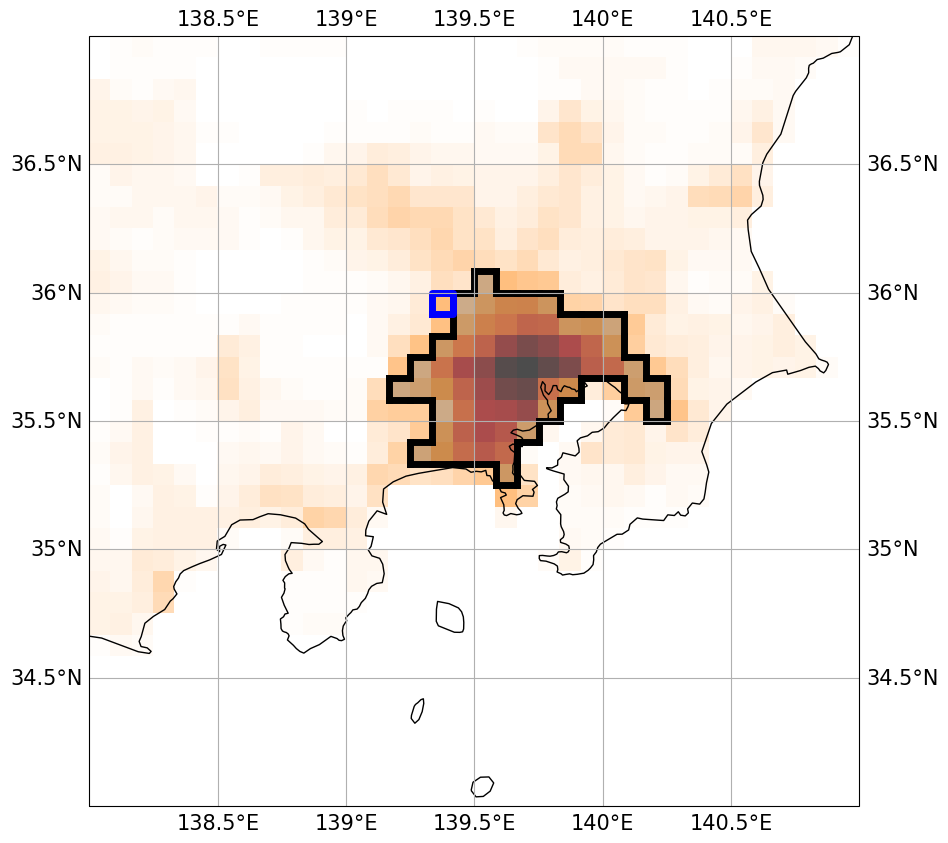

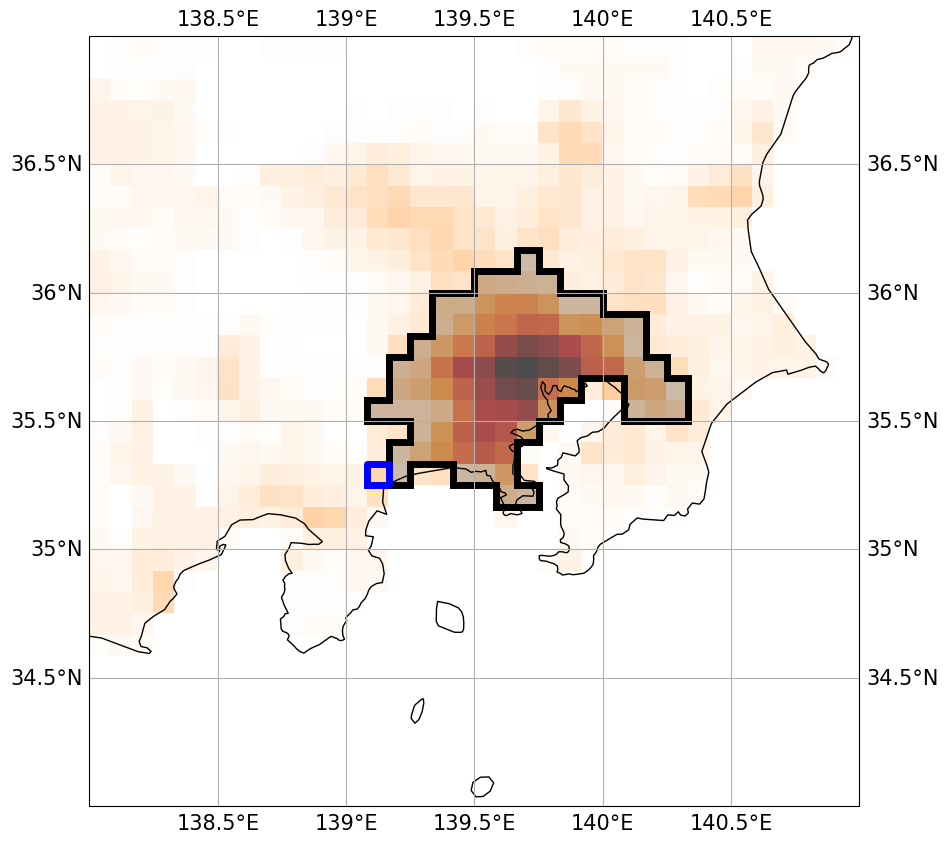

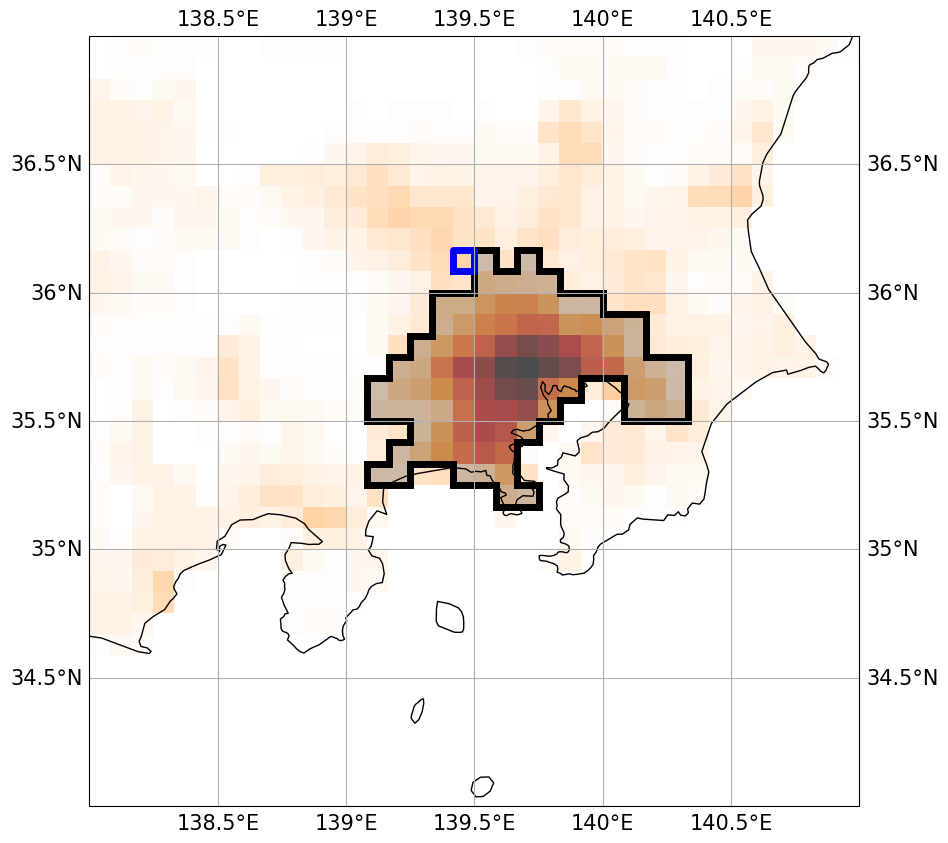

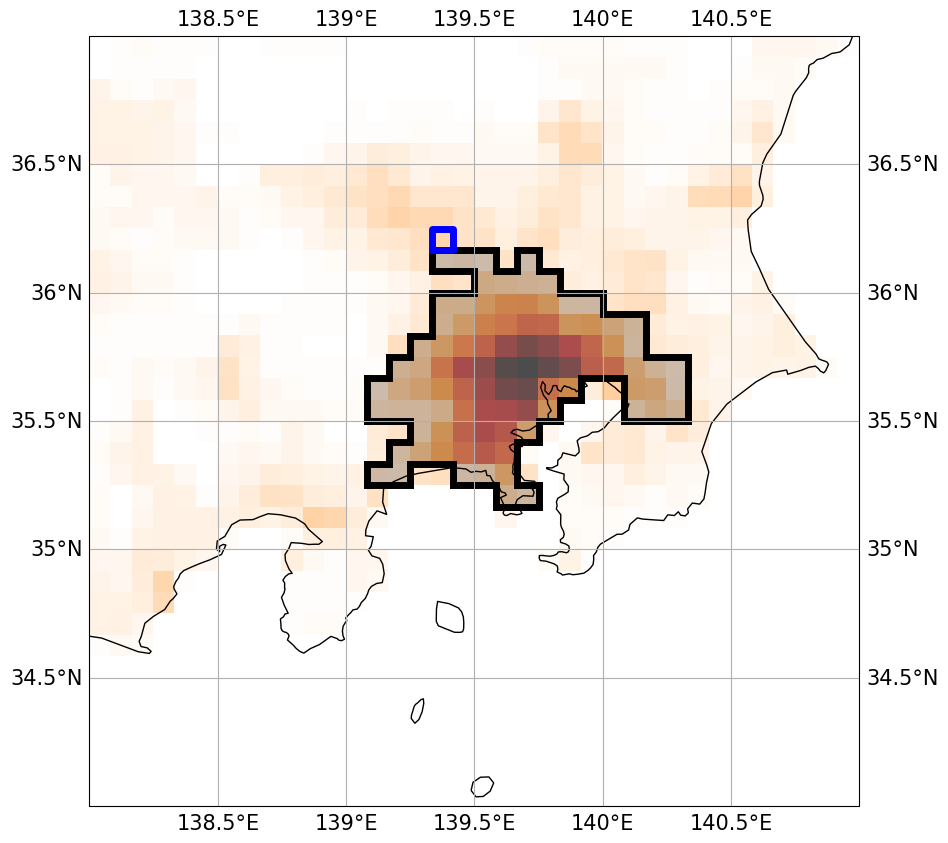

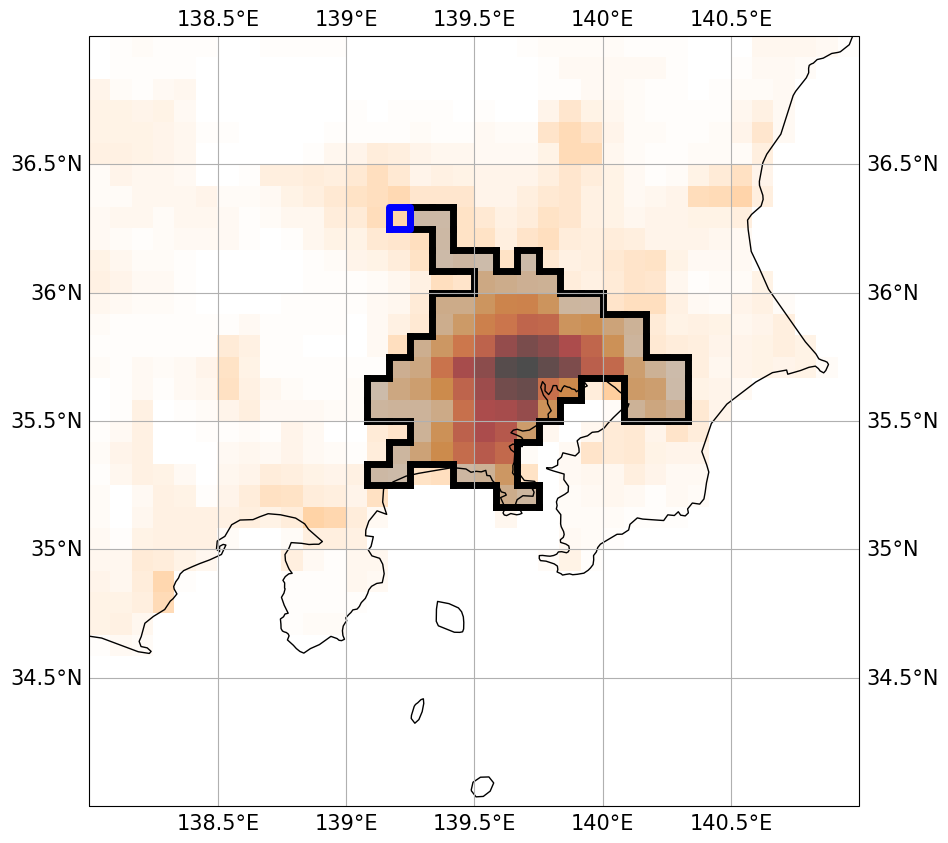

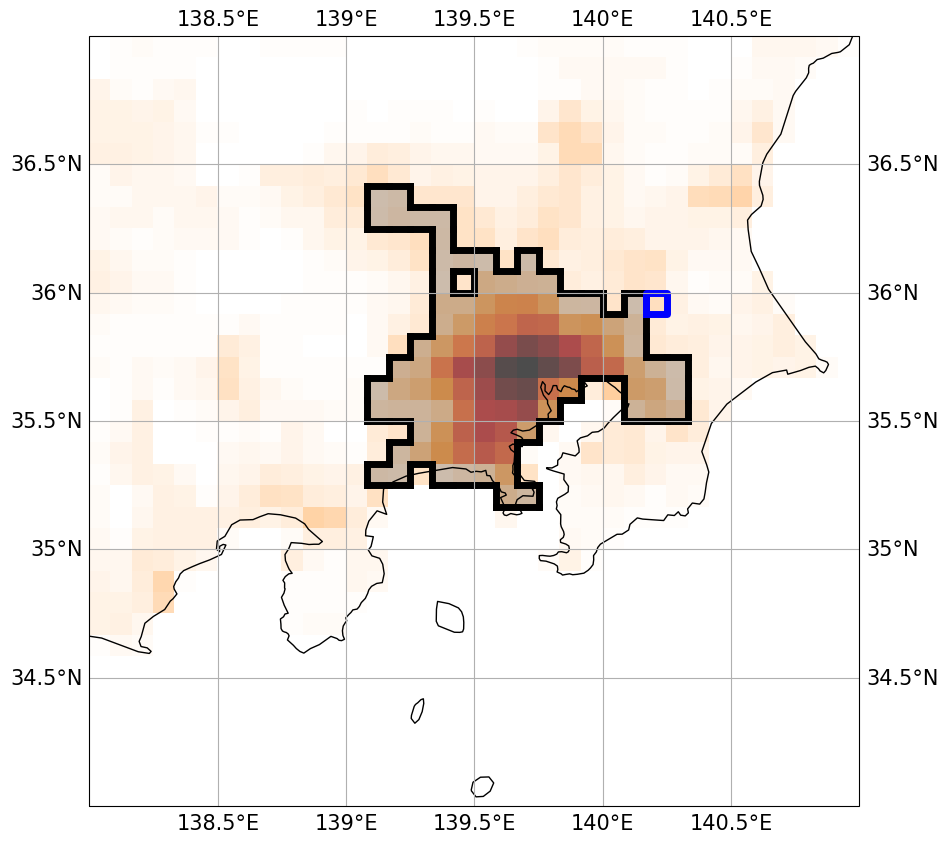

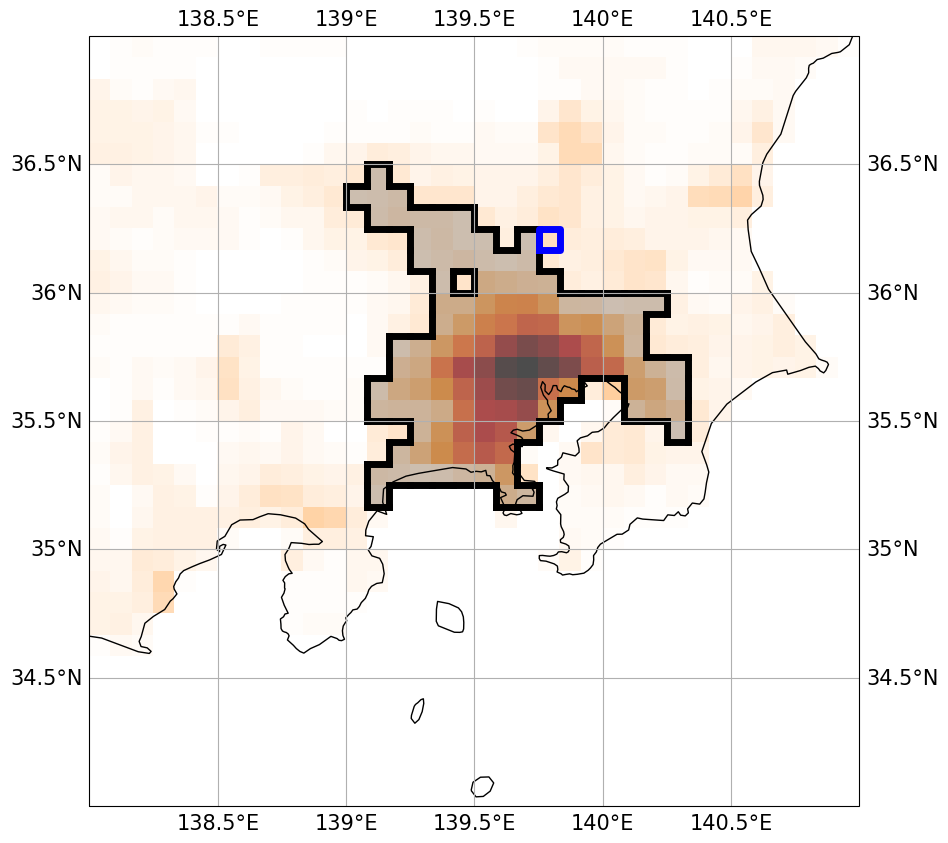

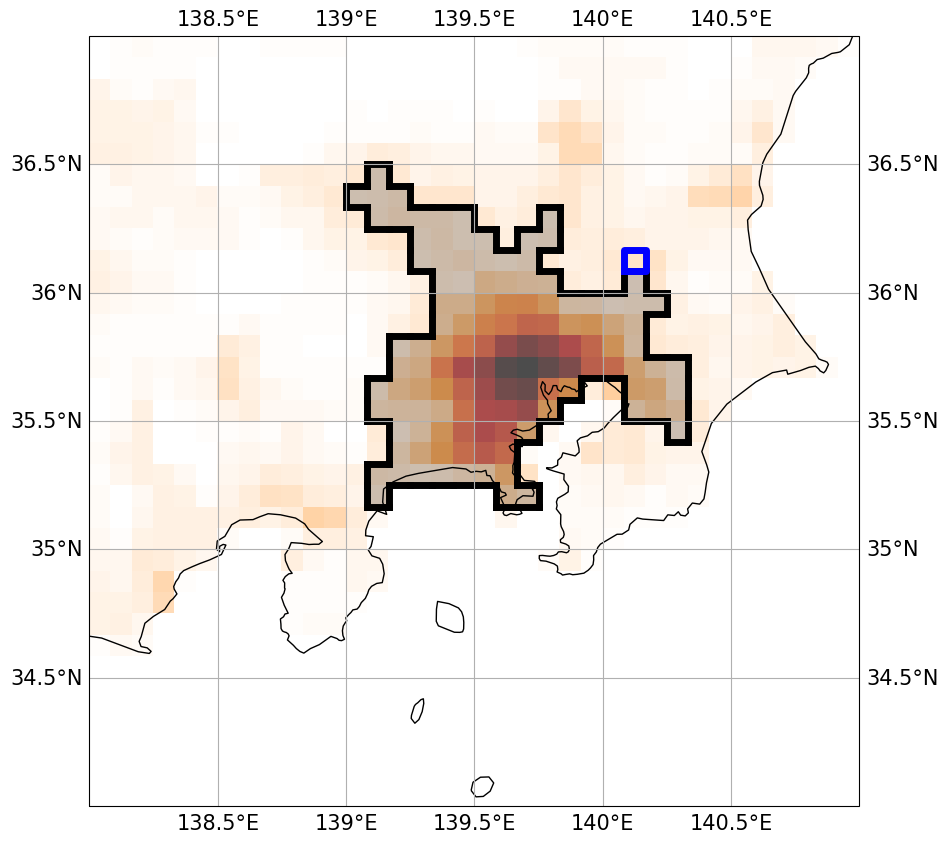

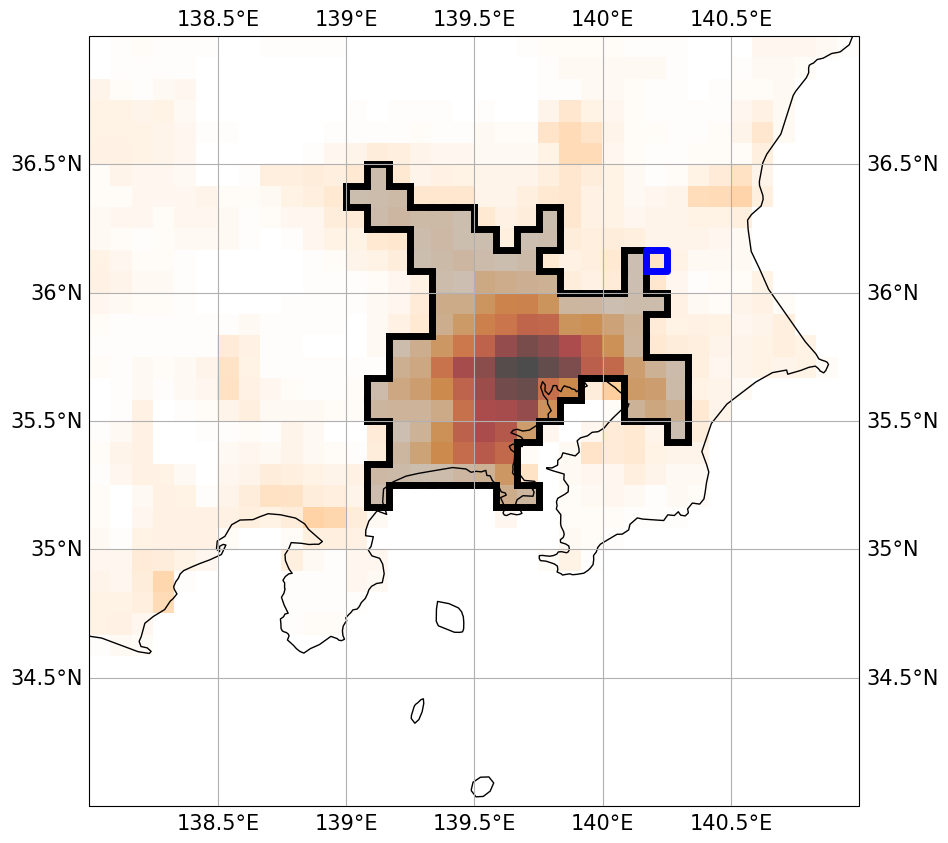

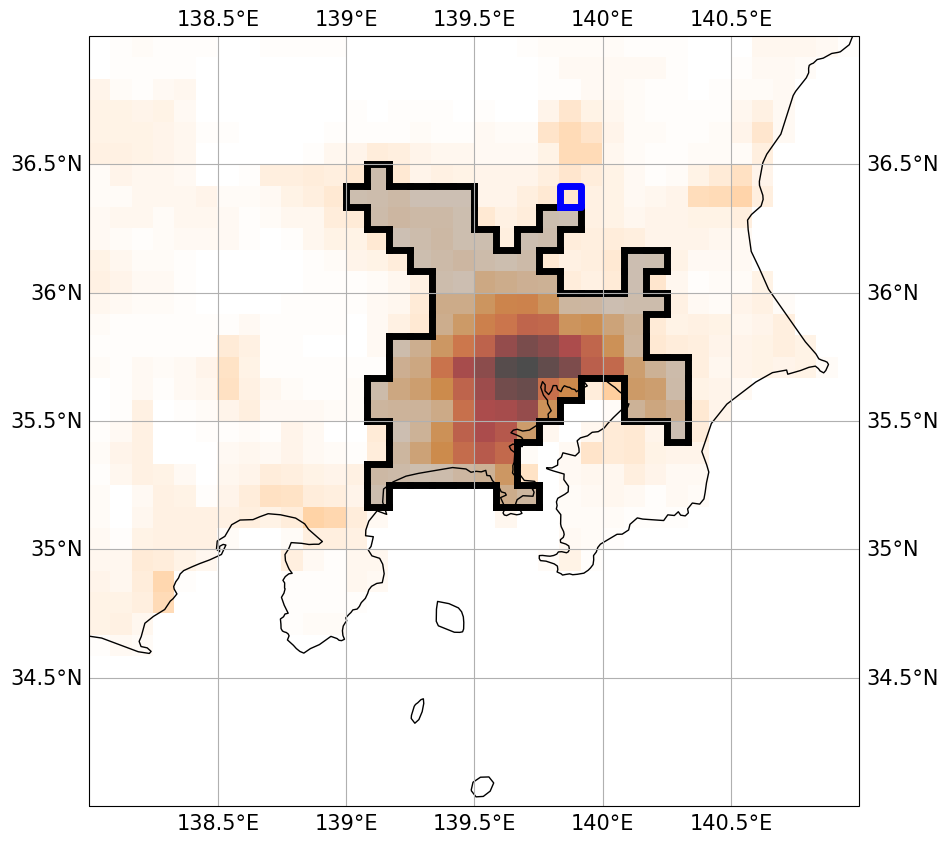

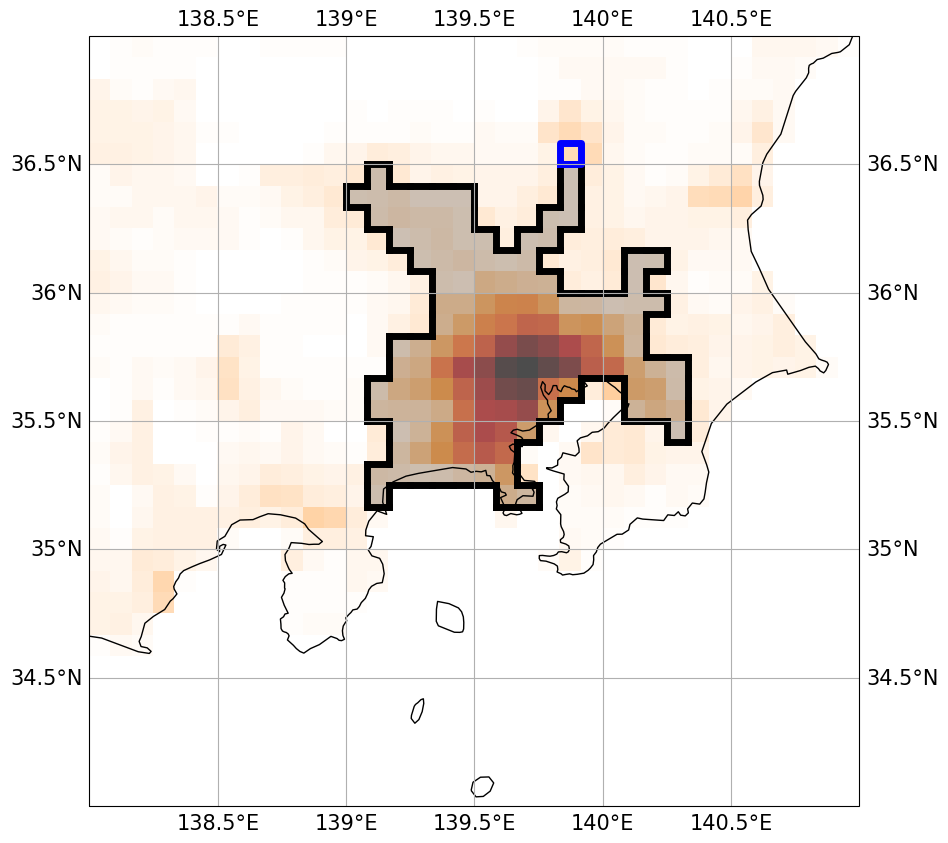

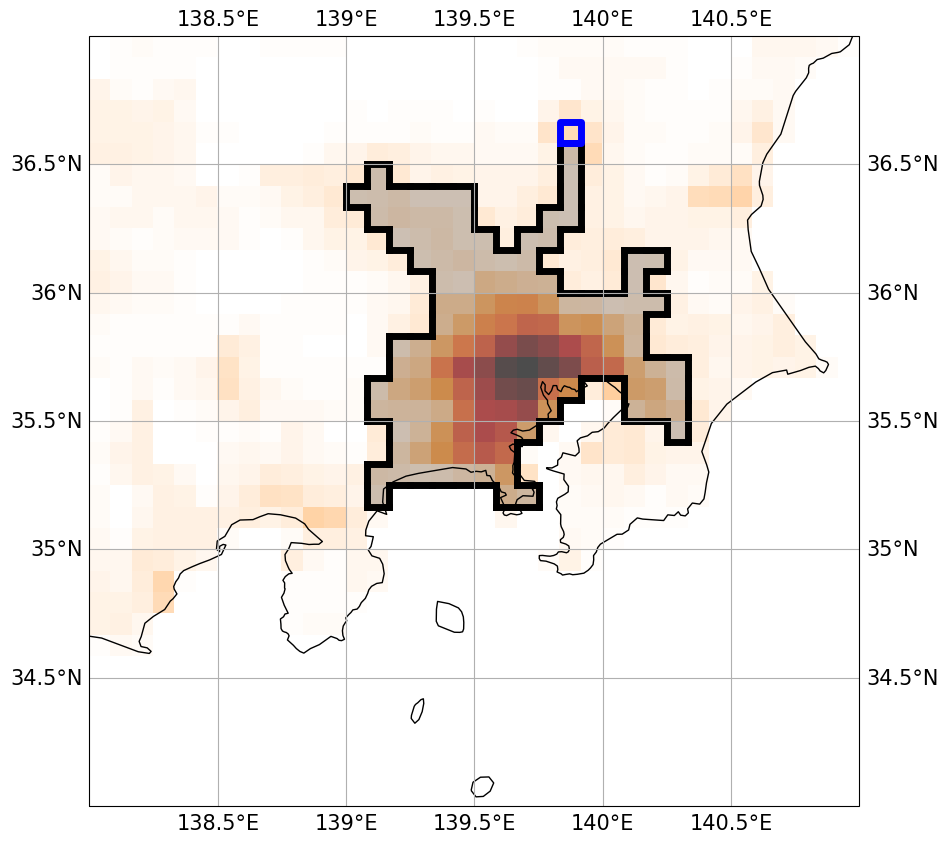

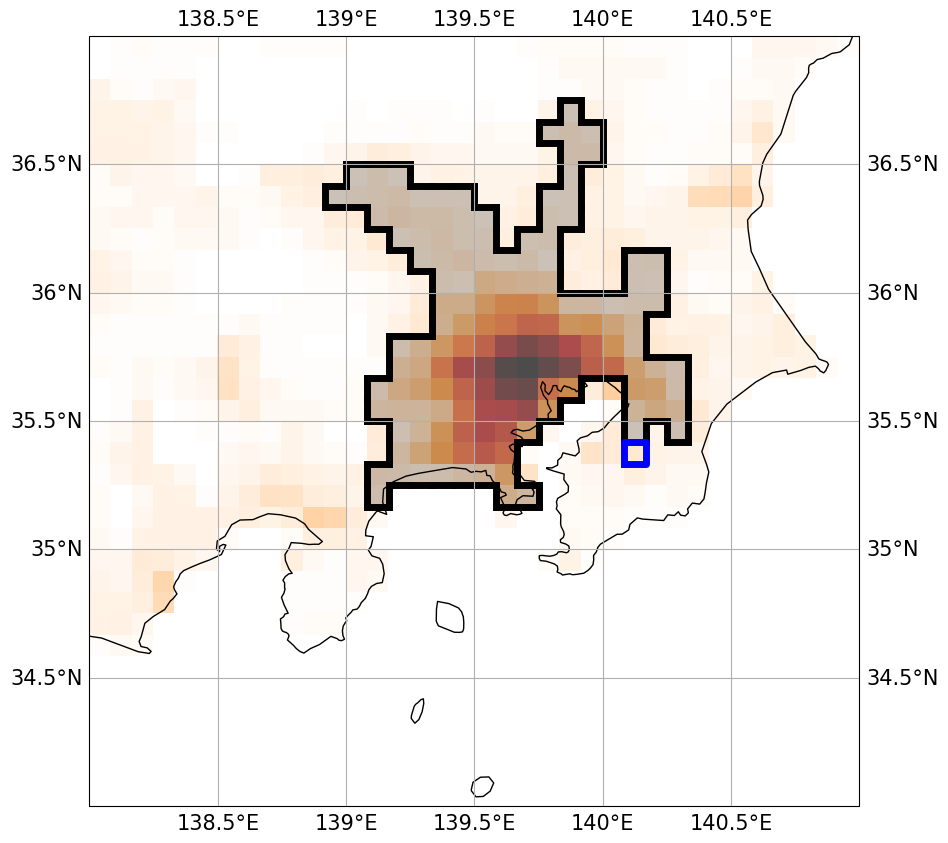

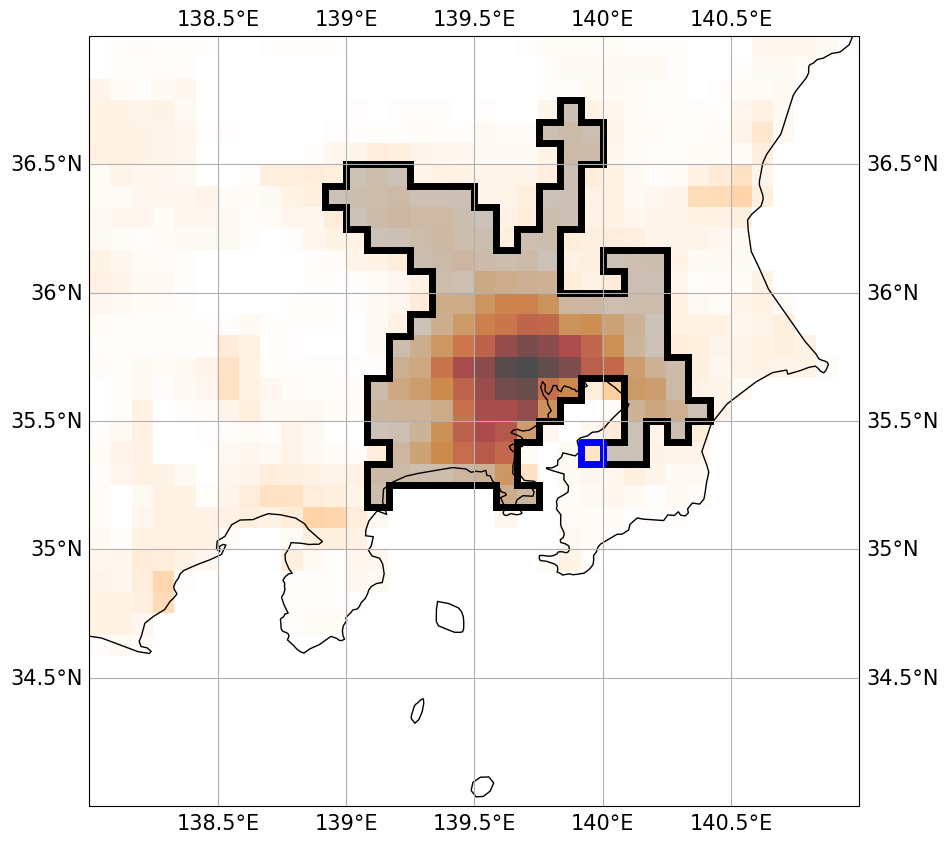

In [30]:
for mask_num in check_list:
    mask_tmp = bestmask_trace[:, :, mask_num-1]
    prv = density_trace[mask_num-1]
    nxt = nextdensity_trace[mask_num-1]
    pop = totalpop_trace[mask_num-1]
    cov = coverage_trace[mask_num-1]
    cor = nextcoords_trace[mask_num-1]
    
    draw_mask(mask_tmp, gwp_pop_density, city_index, np.round(prv), np.round(nxt), pop, un_pop, cov, cor)
    print(mask_num)